# <center> Ovarian Cancer Lipidome Dynamics in a _Dicer-Pten_ <br> Double-Knockout Mouse Model </center>

## <center> `survival analysis` </center>

#### <center>`Olatomiwa O. Bifarin, Ph.D.`</center> <center>Postdoctoral Fellow</center> <center>School of Chemistry & Biochemistry</center> <center>Georgia Institute of Technology </center> <img src="images/GTlogo.png" style="width:100px;height:100px"/> 

## Notebook Content

<a id='0'></a>

1. [Introduction](#1) <font color='red'> This section is not updated</font> <br> 
2. [Survival Analysis, an Introduction](#2) <br>
    2.1.  [Survival Function](#2.1) <br>
3. [Kaplan-Meier Estimate for Controls vs. DKO](#3)<br>
    3.1. [Log Rank Test, Controls _vs._ DKO](#3.1) <br>
    3.2. [Restricted Mean Survival Times (RMST), Controls _vs._ DKO](#3.2) <br>
4. [Hazard Function](#4) <br>
    4.1. [Nelson-Aalen Estimate for Controls _vs._ DKO](#4.1) <br>
5. [Prognostic Circulating Lipid Candidates](#5) <br>
    5.1. [Proposed methods](#5.1) <br>
    5.2. [Feature Selection: Volcano plots DKO _vs_ base DKO](#5.2) <br>
    5.3. [Prognostic Lipid Candidates from Volcano Plots](#5.3) <br>
    5.4. [Feature Selection: _T_-test results from DKO _vs_ Control Comparison](#5.4) <br> 
    5.5. [Prognostic Lipid Candidates from _T_-test DKO _vs_ Control Comparison](#5.5) <br>
    5.6. [RMST for Prognostic Circulating Lipids Candidates](#5.6) <br>
6. [Reading List and Code References](#6)

In [1]:
#from sksurv.datasets import load_veterans_lung_cancer
#pip install scikit-survival
# first attempt at installing
# install lifeline library.

**Import some standard libraries**

In [2]:
import lifelines
import pandas as pd
import numpy as np
from lifelines.plotting import plot_lifetimes
from matplotlib import pyplot as plt    
# More sharp and legible graphics
%config InlineBackend.figure_format = 'retina'
#To ignore warning
import warnings
warnings.filterwarnings('ignore')

## 1. Introduction
<a id='1'></a>

## 2. Survival Analysis, an Introduction
<a id='2'></a>

**Survival analysis** is a group of stastistical/machine learning analysis for which the outcome variable of interest is `time until an event occurs.` 
For this analysis: 
> `time==weeks`, and `event==mice death.`

`Censoring`: don’t know survival time exactly.

<img src="images/censoring_example.png" width=700 height=700 />

In [3]:
# import survival analysis data
df_mouse = pd.read_excel('data/survival_analysis_data.xlsx')

**Note that all mice of age 46 were considered censored**

This include controls: `NC15, NC16, NC17` <br>
This include DKO: `P18, P21, P22`

In [4]:
df_mouse.head()

,id,age,event,group
0,NC1,32,1,control
1,NC2,32,1,control
2,NC4,44,1,control
3,NC6,44,1,control
4,NC7,44,1,control


In [5]:
age = df_mouse['age']
event = df_mouse['event']

**Lifetime plot**

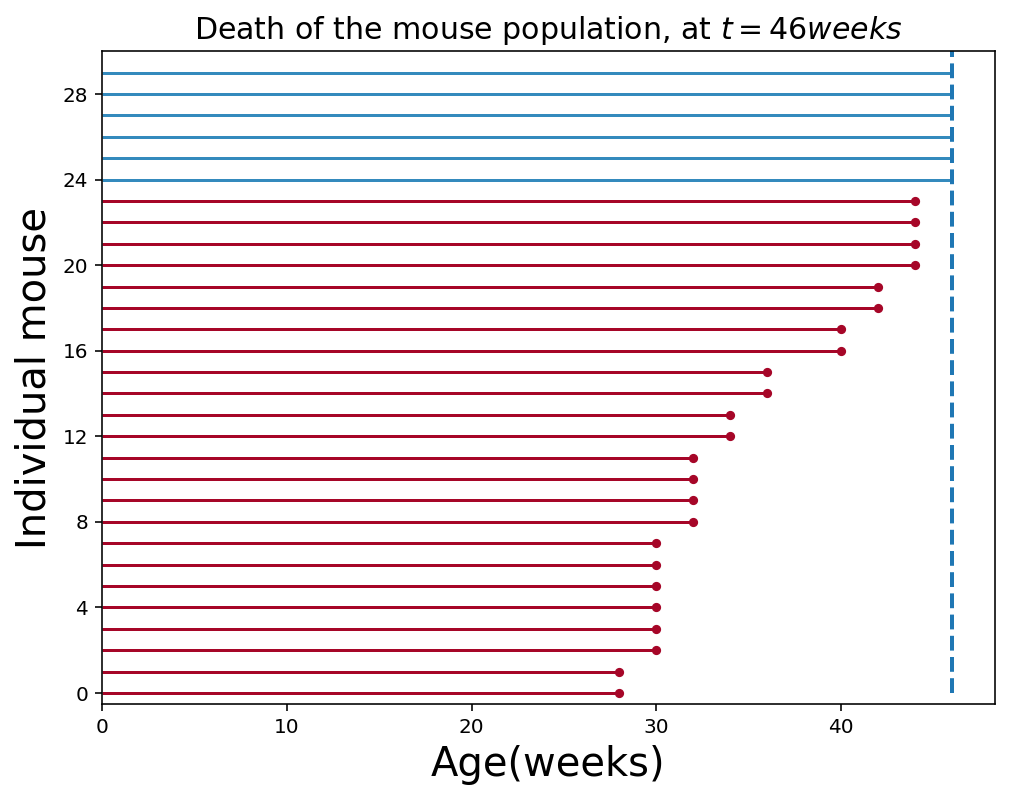

In [6]:
#fig = plt.figure()
plt.figure(figsize=(8,6))
ax = plot_lifetimes(age, event_observed=event)
ax.vlines(46, 0, 30, lw=2, linestyles='--')
ax.set_xlabel("Age(weeks)", fontsize=20)
ax.set_ylabel("Individual mouse", fontsize=20)
ax.set_title("Death of the mouse population, at $t=46 weeks$", 
             fontsize=15);

### [Go to Table of Contents](#0) <br>

### 2.1 Survival Function

<a id='2.1'></a>

**Survival function**: $S(t)$ gives the probability that a mouse survives longer than some specified time $t$: that is, $S(t)$ gives the probability that $T$ exceeds the specified time $t$. <br>

$$ \large S(t) = P(T > t)$$ <br>
$S(t)$ = survivor function <br>
$T$ = Mouse’s survival time <br>
$t$ = Specific time of interest for $T$

<img src="images/survival_curve.png" width=300 height=300 />

**Why do we need a survival function if we can estimate descriptive statistics for the average survival time and average hazard rate?** 

Descriptive statistics provide overall comparisons but do not compare groups at different times during ovarian cancer progression (compared to control group)

### Survival table 

| Ordered death times $t_{(f)}$| # of death $m_{(f)}$ | # censored $q_{(f)}$ | Risk set, $R (t_{(f)})$|
| --- | --- | --- |--- |
| $t_{(0)}$ = 0 | $m_{(0)}$ = 0 | $q_{(0)}$ | $R(t_{(0)})$|
| $t_{(1)}$  | $m_{(1)}$ | $q_{(1)}$ |$R(t_{(1)})$ |
|$t_{(2)}$| $m_{(2)}$ | $q_{(2)}$ | $R(t_{(2)})$|
|.|.|.|.|
|.|.|.|.|
|$t_{(k)}$| $m_{(k)}$ |$q_{(3)}$| $R(t_{(k)})$ |

- The first column in the table gives ordered survival times from smallest to largest. (`ordered death times` $t_{(f)}$) 
- The second column gives frequency counts of death at each distinct death time. 
- The third column gives frequency counts, denoted by $ q_{(f)}$, of those mice censored in the time interval starting with death time $t_{(f)}$) up to but not including the next death time, denoted by $t_{(f+1)}$. That is: $[t_{(f)}, t_{(f+1)})$ 
- The last column gives the risk set $R(t_{(f)})$, which denotes the collection of mice who have survived at least to time $t_{(f)}$.

In [7]:
from lifelines.utils import survival_table_from_events

table = survival_table_from_events(df_mouse['age'], df_mouse['event'])
table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,30,30
28.0,2,2,0,0,30
30.0,6,6,0,0,28
32.0,4,4,0,0,22
34.0,2,2,0,0,18
36.0,2,2,0,0,16
40.0,2,2,0,0,14
42.0,2,2,0,0,12
44.0,4,4,0,0,10


### Kaplan-Meier Estimate

$$ \large \hat{S}(t_{(f)}) =  \prod_{i=1}^{f} \hat{P}r[T > t_{(i)} | T \ge t_{(i)}] $$ <br>

$$ = \large \hat{S}(t_{(f-1)}) \times \hat{P}r(T > t_{(f)} | T \ge t_{(f)})  $$ <br>

$$  \large \hat{S}(t) =  \prod_{t_{i} < t} (1 - \frac {d_{i}}{n_{i}}) $$ <br>

Where 
- $d_{i}$ are the number of death events at time $t$ 
- $n_{i}$ is the number of mice at risk of death just prior time $t$

In [8]:
table.iloc[0:4,] #first four timepoints

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,30,30
28.0,2,2,0,0,30
30.0,6,6,0,0,28
32.0,4,4,0,0,22


$$  \large \hat{S}(t) =  \prod_{t_{i} < t} (1 - \frac {d_{i}}{n_{i}}) $$ <br>
$ \large \hat{S}(28) =  (1 - \frac {2}{30}) = 0.933 $ <br>
$ \large \hat{S}(30) =  0.933(1 - \frac {6}{28}) = 0.933 \times 0.786 = 0.733 $  <br>
$ \large \hat{S}(32) =  0.733(1 - \frac {4}{22}) = 0.733 \times 0.818 = 0.600 $  <br>
$ \large ... $

In [9]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(age, event_observed=event)  # or, more succinctly, kmf.fit(T, E)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 30 total observations, 6 right-censored observations>

In [10]:
kmf.survival_function_

,KM_estimate
timeline,
0.0,1.000000
28.0,0.933333
30.0,0.733333
32.0,0.600000
34.0,0.533333
36.0,0.466667
40.0,0.400000
42.0,0.333333
44.0,0.200000


In [11]:
kmf.cumulative_density_

,KM_estimate
timeline,
0.0,0.000000
28.0,0.066667
30.0,0.266667
32.0,0.400000
34.0,0.466667
36.0,0.533333
40.0,0.600000
42.0,0.666667
44.0,0.800000


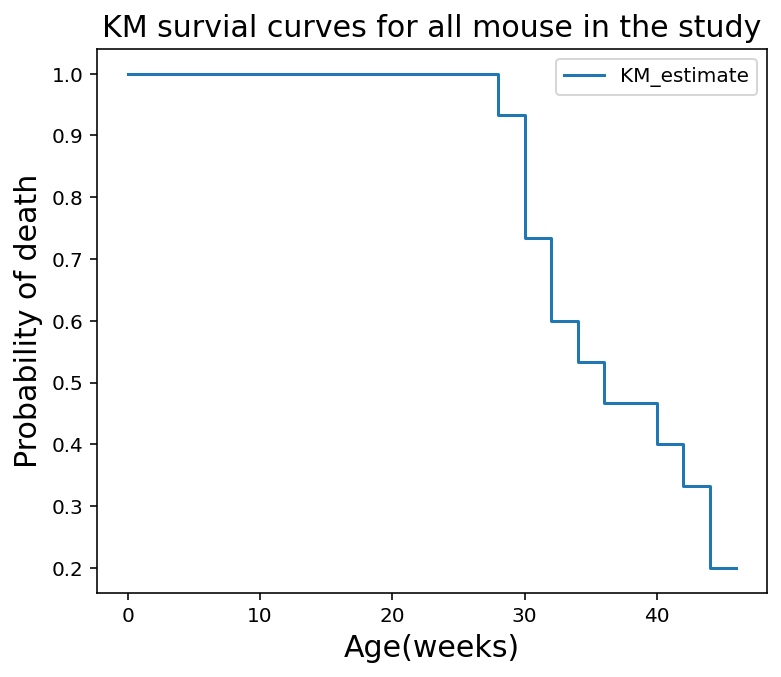

In [12]:
plt.figure(figsize=(6,5))
ax = kmf.plot_survival_function(ci_show=False);
ax.set_xlabel("Age(weeks)", fontsize=15)
ax.set_ylabel("Probability of death", fontsize=15);
ax.set_title("KM survial curves for all mouse in the study", 
             fontsize=15);

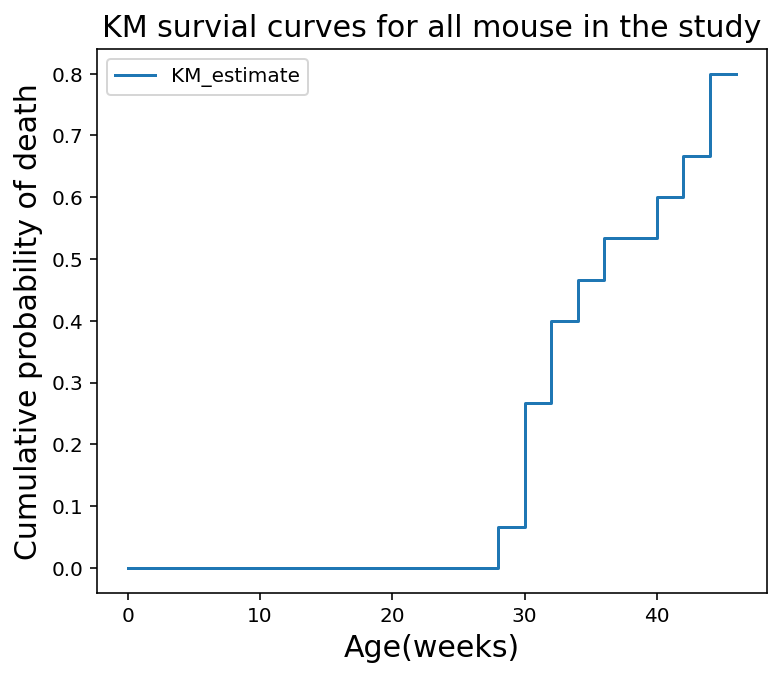

In [13]:
plt.figure(figsize=(6,5))
ax = kmf.plot_cumulative_density(ci_show=False);
ax.set_xlabel("Age(weeks)", fontsize=15)
ax.set_ylabel("Cumulative probability of death", fontsize=15);
ax.set_title("KM survial curves for all mouse in the study", 
             fontsize=15);

In [14]:
from lifelines.utils import median_survival_times

In [15]:
sample_median_st = kmf.median_survival_time_
sample_median_ci = median_survival_times(kmf.confidence_interval_)
print('median survival time for all samples is: ', sample_median_st, 'weeks')
print(sample_median_ci)

median survival time for all samples is:  36.0 weeks
     KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5                    32.0                    44.0


## 3. Kaplan-Meier Estimate for Controls _vs._ DKO
<a id='3'></a>

In [16]:
df_mouse['group'];

In [17]:
groups =df_mouse['group']
ix = (groups == 'DKO')

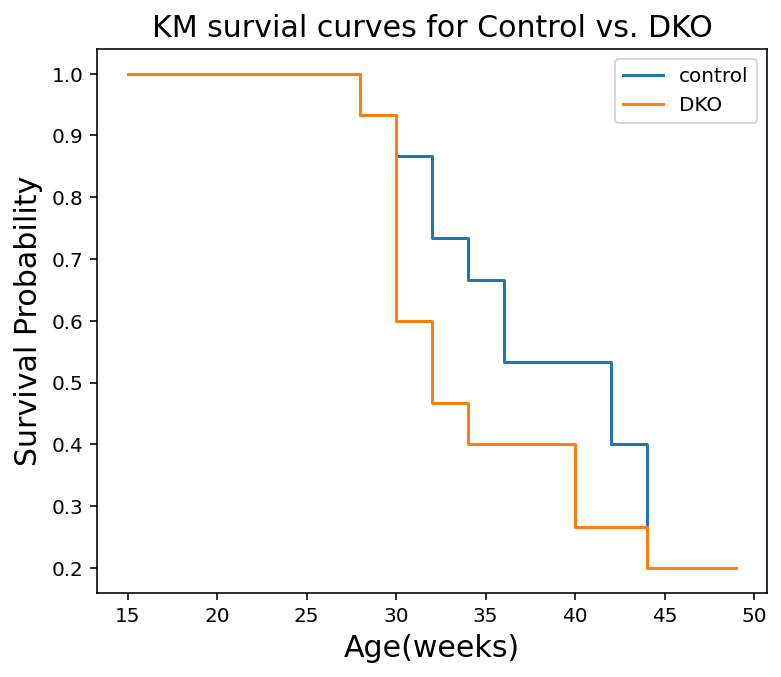

In [18]:
plt.figure(figsize=(6,5))
kmf.fit(age[~ix], event[~ix], label='control', timeline=range(15, 50))
ax = kmf.plot_survival_function(ci_show=False)

#plt.figure(figsize=(6,5))
kmf.fit(age[ix], event[ix], label='DKO', timeline=range(15, 50))
ax = kmf.plot_survival_function(ax=ax, ci_show=False)

ax.set_xlabel("Age(weeks)", fontsize=15)
ax.set_ylabel("Survival Probability", fontsize=15);
ax.set_title("KM survial curves for Control vs. DKO", 
             fontsize=15);
#plt.savefig('KM-dko-control.svg')

### [Go to Table of Contents](#0) <br>

### 3.1 Log Rank Test, Controls _vs._ DKO
<a id='3.1'></a>

Are KM curves statistically equivalent?

In [19]:
from lifelines.statistics import logrank_test

age_exp, event_exp = df_mouse.loc[ix, 'age'], df_mouse.loc[ix, 'event']
age_con, event_con = df_mouse.loc[~ix, 'age'], df_mouse.loc[~ix, 'event']

results = logrank_test(age_exp, 
                       age_con, 
                       event_observed_A = event_exp, 
                       event_observed_B = event_con, 
                       weightings = 'peto')

In [20]:
results.print_summary()

<lifelines.StatisticalResult: Peto_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = Peto_test

---
 test_statistic    p  -log2(p)
           1.37 0.24      2.05

In [21]:
print(results.p_value)
print(results.test_statistic)

0.24190089885801186
1.3694820252539521


### Survival differences at fixed point in time

In [22]:
from lifelines.statistics import survival_difference_at_fixed_point_in_time_test

In [23]:
age_exp, event_exp = df_mouse.loc[ix, 'age'], df_mouse.loc[ix, 'event']
age_con, event_con = df_mouse.loc[~ix, 'age'], df_mouse.loc[~ix, 'event']

kmf_exp = KaplanMeierFitter(label='DKO').fit(age_exp, event_exp)
kmf_con = KaplanMeierFitter(label='control').fit(age_con, event_con)

point_in_time = 40

results = survival_difference_at_fixed_point_in_time_test(point_in_time,
                                                         kmf_exp,
                                                         kmf_con)

In [24]:
results.print_summary()

<lifelines.StatisticalResult: survival_difference_at_fixed_point_in_time_test>
 null_distribution = chi squared
degrees_of_freedom = 1
     point_in_time = 40
           fitterA = <lifelines.KaplanMeierFitter:"DKO", fitted with 15 total observations, 3 right-censored observations>
           fitterB = <lifelines.KaplanMeierFitter:"control", fitted with 15 total observations, 3 right-censored observations>
         test_name = survival_difference_at_fixed_point_in_time_test

---
 test_statistic    p  -log2(p)
           1.71 0.19      2.39

### [Go to Table of Contents](#0) <br>

### 3.2 Restricted Mean Survival Times (RMST), Controls _vs._ DKO
<a id='3.2'></a>

$$ \large \text{RMST}(t) = \int_0^t S( \tau) d \tau$$ <br>

In [25]:
from lifelines.utils import restricted_mean_survival_time
from matplotlib import pyplot as plt
from lifelines.plotting import rmst_plot

In [26]:
time_limit = 46
age, event = df_mouse['age'], df_mouse['event']

kmf_exp = KaplanMeierFitter().fit(age[ix],event[ix], label='DKO')
rmst_exp = restricted_mean_survival_time(kmf_exp, t=time_limit)

kmf_con = KaplanMeierFitter().fit(age[~ix],event[~ix], label='control')
rmst_con = restricted_mean_survival_time(kmf_con, t=time_limit)

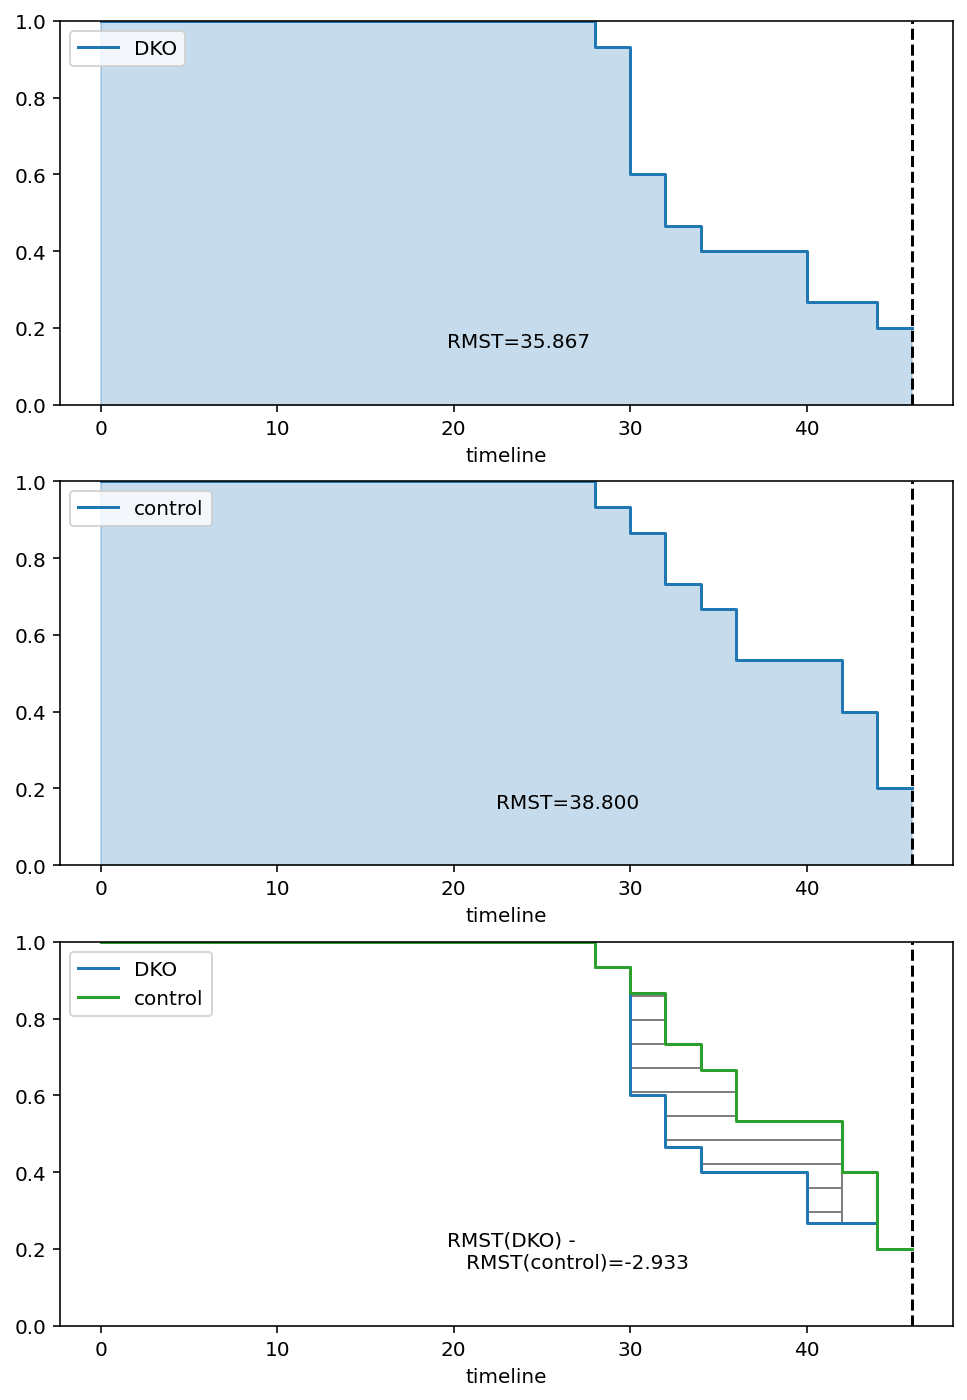

In [27]:
plt.figure(figsize=(6,5))
ax = plt.subplot(311)
rmst_plot(kmf_exp, t=time_limit, ax=ax, figsize=(8,12))


ax = plt.subplot(312)
rmst_plot(kmf_con, t=time_limit, ax=ax)


ax = plt.subplot(313)
rmst_plot(kmf_exp, model2=kmf_con, t=time_limit, ax=ax);
#plt.savefig('RMST-dko-control.svg')

### Some obersevations: 
- From the KM curves, we can see that starting from 30 weeks, the probability of survival in DKO and control starts to diverge. 
- However, for DKO animals that survive till 44 weeks, probability of survival is the same with controls. That is if a DKO animals survives beyond 44 weeks, the risk of dying of DKO is similar to the controls.

### [Go to Table of Contents](#0) <br>

## 4. Hazard Function

<a id='4'></a>

**Hazard function**: $h(t)$ gives the instantaneous potential per unit time (week) for the event(death) to occur, given that the mouse has survived up to time $t$. 

$$ \large h(t) = \lim_{\Delta t \to 0} \dfrac {P(t \le T < t + \Delta t | T \ge t)}{\Delta t}$$ <br>

$P(t \le T < t + \Delta t | T \ge t) = P (\text {mouse dies in the interval } [t, t+\Delta t] | \text{ survival up to time } t)$ <br>
Hazard function = conditional failure rate. <br>
In order words, $h(t)$ gives the instantaneous potential for death at time $t$ per unit time, given survival up to time $t$.

$h(t)$ = hazard function <br>

<img src="images/hazard_curve.png" width=300 height=300 />

Note that, in contrast to the survivor function, which focuses on not having an event, the hazard function focuses on the event occurring

$$  \large \hat{H}(t) =  \sum_{t_{i} < t} \frac {d_{i}}{n_{i}} $$ <br>

Where 
- $d_{i}$ are the number of death events at time $t$ 
- $n_{i}$ total mice at risk at time $t_{i}$

In [28]:
table.iloc[:4, ]

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,30,30
28.0,2,2,0,0,30
30.0,6,6,0,0,28
32.0,4,4,0,0,22


$$  \large \hat{H}(t) =  \sum_{t_{i} < t} \frac {d_{i}}{n_{i}} $$ <br>

$ \large \hat{H}(28) =  \frac {2}{30} = 0.067 $ <br>
$ \large \hat{H}(30) =  \frac {2}{30} + \frac {6}{28} = 0.304 $  <br>
$ \large \hat{H}(32) =  \frac {2}{30} + \frac {6}{28} + \frac {4}{22} = 0.499 $  <br>
$ \large ... $

In [29]:
from lifelines import NelsonAalenFitter

In [30]:
naf = NelsonAalenFitter()
naf.fit(age, event_observed=event)

<lifelines.NelsonAalenFitter:"NA_estimate", fitted with 30 total observations, 6 right-censored observations>

In [31]:
naf.cumulative_hazard_

,NA_estimate
timeline,
0.0,0.000000
28.0,0.067816
30.0,0.304174
32.0,0.499879
34.0,0.614258
36.0,0.743425
40.0,0.891776
42.0,1.066019
44.0,1.544987


### Nelson-Aalen Curve

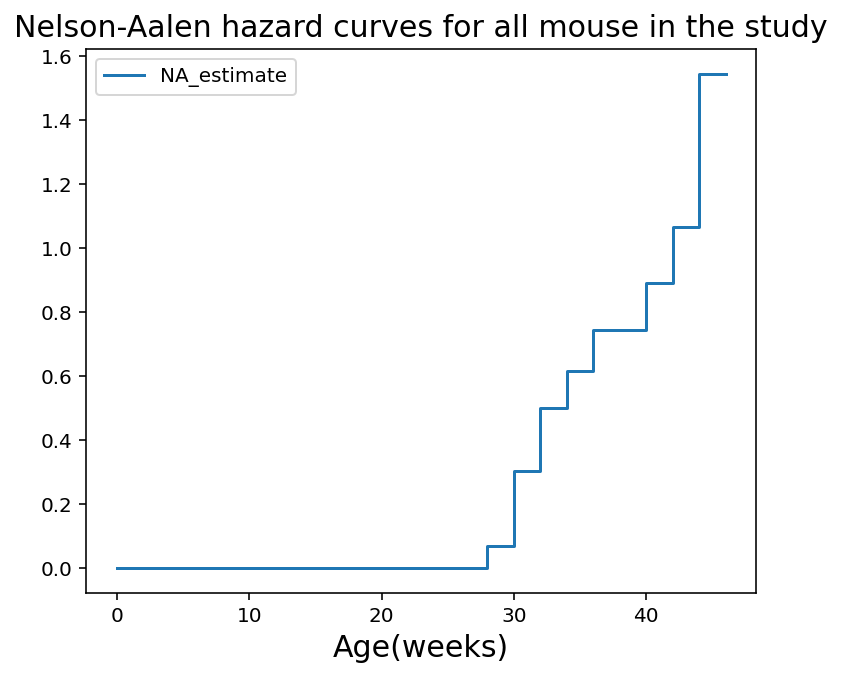

In [32]:
plt.figure(figsize=(6,5))
ax = naf.plot_cumulative_hazard(ci_show=False)
ax.set_xlabel("Age(weeks)", fontsize=15)
#ax.set_ylabel("Probability of death", fontsize=15);
ax.set_title("Nelson-Aalen hazard curves for all mouse in the study", 
             fontsize=15);

### [Go to Table of Contents](#0) <br>

### 4.1 Nelson-Aalen Estimate for Controls _vs._ DKO

<a id='4.1'></a>

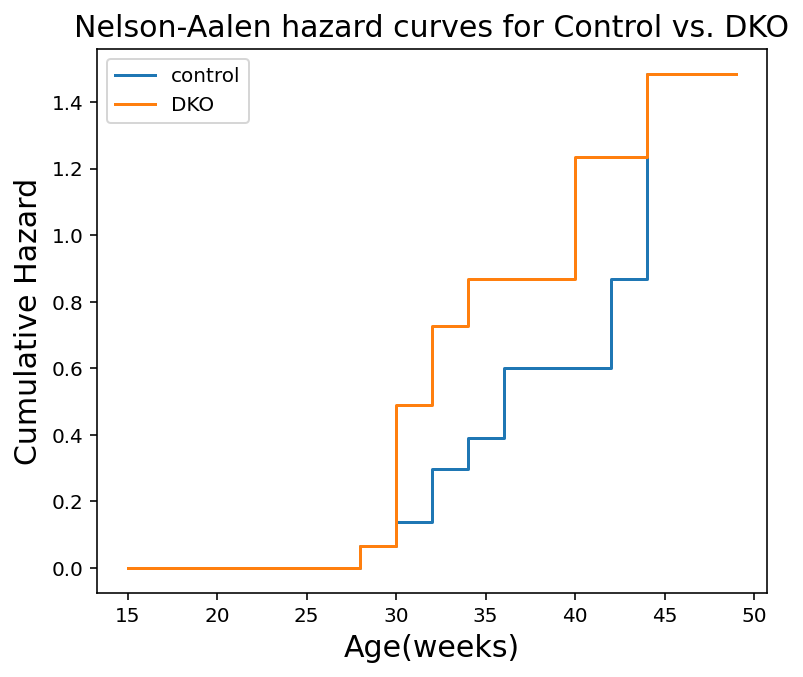

In [33]:
plt.figure(figsize=(6,5))
naf.fit(age[~ix], event[~ix], label='control', timeline=range(15, 50))
ax = naf.plot_cumulative_hazard(ci_show=False)

naf.fit(age[ix], event[ix], label='DKO', timeline=range(15, 50))
ax = naf.plot_cumulative_hazard(ax=ax, ci_show=False)

ax.set_xlabel("Age(weeks)", fontsize=15)
ax.set_ylabel("Cumulative Hazard", fontsize=15);
ax.set_title("Nelson-Aalen hazard curves for Control vs. DKO", 
             fontsize=15);
#plt.savefig('NA-dko-control.svg')

### [Go to Table of Contents](#0) <br>

## 5. Identification of Prognostic Circulating Lipid Candidates. 

<a id='5'></a>

### 5.1 Proposed methods

<a id='5.1'></a>

- <s>Use a simple volcano plot to compare base DKO metabolites to all stages. Select a cut off score, and identify overlapping metabolites across stages.</s>  
- <s>For the selected metabolites, compute a median split, log rank test, and K-M curves.</s> 

**If attempting Cox Regression**
- Attempt plotting volcano plot: -Log10(qvalue) against regression coefficient in Cox regression.  
- Presently, I have only used Cox Time Varying regression, use the normal Cox model, and see results. 
- As an alternative, for the selected metabolite classify into metabolite x increased _vs_ decreased or increased by 50% _vs_ decreased by less than 50% or use different quantile cut-off.
- Compute Cox proportional hazards regression test for each metabolite selected, calculate the HR value. Factors with _p_-values < 0.05 were considered to have prognostic significance. Please read this papers [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7479226/pdf/fonc-10-01545.pdf) and [here](https://www.nature.com/articles/s41467-019-12361-9.pdf) (completed).
- Assess Cox model using residuals see [here](https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Cox%20residuals.html). Also, see the _Cancers_ paper, Miolo _et al_ 2020.
- Read also, see the _Cancers_ paper, [Miolo _et al_ 2020](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7409362/) carefully, lots of ideas. 
- Final note, while computing CPH test, A useful rule of thumb is that you should limit your analysis to no more than 1 predictor per 10-20 events (recurrences or deaths in oncology) in a standard Cox multiple-regression model. See [here](https://stats.stackexchange.com/questions/220392/whats-the-difference-between-univariate-and-multivariate-cox-regression) and [here](https://www.researchgate.net/post/Statistical-significance-of-variables-between-univariate-vs-multivariate-analysis-using-COX-model) for discussions. 

In [34]:
df = pd.read_excel('data/dko_annotated_updated.xlsx')

<div class="alert alert-block alert-success">
- `id`: refers to the combined `mice` sample id underscore `timepoint`, which are already made to have there own distinctive columns. <br>
- `age`: refers to the age of mice in weeks when blood samples are collected. <br>
- `lifetime`: since mice dies at different times by the effect of ovarian cancer, then % lifetime features is calculated for each sample, where %lifetime is the (age in weeks / total life span or age at death) X 100. <br>
- `stage_bin`: see definition above. <br>
- `death`: refers to the total life span or age at death
</div>

In [35]:
df.head();

### Feature Selection

Four feature selection methods to try: 
- <s>T-test results from DKO _vs_ Control for all stages.</s> 
- <s>Volcano plots for DKO _vs_ base DKO.</s>
- Discriminative features from ML for all stages. 
- DKO _vs_ base DKO clustering analysis results from continual increase. 

### [Go to Table of Contents](#0) <br>

### 5.2 Feature Selection: Volcano plots DKO _vs_ base DKO

<a id='5.2'></a>

In [36]:
import scipy
import statsmodels as sms
from statsmodels.stats import multitest

**_T_-test Function**

In [37]:
def Ttest(metabolites, dfControl, dfTreat, alpha=0.05, var=True):
    '''
    Function conducts a T-test for the metabolites differences between two groups with 
    Benjamini-Hocberg FDR correction
    
    Inputs: 
    metabolites = A list containing names of metabolites
    dfControl = A pandas dataframe containing the control group metabolites data
    dfTreat =  A pandas dataframe containing the treatment group metabolites data
    alpha = alpha for statistical significant judgment, default 0.05
    var = If True (default), perform a standard independent 2 sample test that assumes 
    equal population variances [1]. If False, perform Welch’s t-test, which does not 
    assume equal population variance
    
    Outputs: A pandas dataframe with p-values of numerical cohort characteristics. 
    
    '''
    ttest_dict = {}
    for metabolite in metabolites:
        statistic, pvalue =  scipy.stats.ttest_ind(dfControl[metabolite], 
                                               dfTreat[metabolite], 
                                               equal_var=var)
        ttest_dict[metabolite] = pvalue 
        # a dictionary containing name of metabolites and p value after t-test
    ttest = pd.DataFrame.from_dict(ttest_dict, orient='index') # the dictionary in pandas df
    ttest_list=list(ttest_dict.values()) #values (pvalues) of ttest result in a list
    reject, pval_corrected, _, _ = sms.stats.multitest.multipletests(ttest_list, 
                                                                 alpha=alpha, 
                                                                 method='fdr_bh')
    ttest_results = pd.DataFrame({'Metabolite': metabolites, 'T-test p-value': ttest_list, 
                              'FDR p-value': pval_corrected, 'Reject H0': reject})
    Table = ttest_results.sort_values(by=['FDR p-value'])
    return Table

In [38]:
def volcano(dataframe1, stage): 

    '''
    FUNCTION
    volcano function gives the input dataframe for a volcano plot. 
    
    INPUTS
    dataframe1 = dataframe, at the time of writing: dko_annotated_updated.xlsx (pandas dataframe)
    stage = stage bin (string)
    
    OUTPUTS
    Two outputs: 1) the number of samples in each stage bins 2) volcano plots output containing
    a) fold changes b) -log(qvalues)
    
    '''
    
    # Select DKO only dataframe
    DKOdf = dataframe1.loc[dataframe1['group'] == 'DKO']
    
    # Select stage 1 and stage x DKO dataframe.
    dko_base = DKOdf[DKOdf['stage_bin'] == 'I']
    dko_exp = DKOdf[DKOdf['stage_bin'] == stage]
    
    # All metabolomic features
    features = dataframe1.drop(['Unnamed: 0', 'id', 'group', 'mice', 'timepoint', 'age',
                    'lifetime', 'stage_bin', 'death'], axis=1).columns
    
    # Compute mean
    mean = pd.DataFrame({'Features': features.tolist(),
                                 'dko_base': dko_base[features].mean(axis=0),
                                 'dko_exp': dko_exp[features].mean(axis=0)
                                })
    
    # Reset index for the mean dataframe
    mean.reset_index(drop=True)
    
    # log2 fold changes (dkox/dkobase)
    fc_changes = [np.log2(oc/ctr) for oc, ctr in zip(mean['dko_exp'], mean['dko_base'])]
    
    # compute ttest and use Welch, because sample size is imbalanced.
    ttest_result = Ttest(features, dko_base, dko_exp, alpha=0.05, var=False)
    
    # sort index
    tTestDF = ttest_result.sort_index()
    
    # set up volano plot dataframe
    volcanoDF = pd.DataFrame({
        'Features': mean['Features'], 
        'Log2Fold': fc_changes,
        'p-value': tTestDF['T-test p-value'].tolist()
    }) # To get get q values use this "tTestDF['FDR p-value'].tolist()"
    
    # To convert all q-values to -log10(qvalues) use code below.
    #volcanoDF['-log(q-value)'] = volcanoDF['-log(q-value)'].apply(lambda x: -np.log10(x))
    
    return (len(dko_base), len(dko_exp)), volcanoDF

Run the code for the inputs for the volcano plots.

In [39]:
size_stage2, vDF2 = volcano(df, 'II')
size_stage3, vDF3 = volcano(df, 'III')
size_stage4, vDF4 = volcano(df, 'IV')
size_stage5, vDF5 = volcano(df, 'V')

In [40]:
print(size_stage2)
print(size_stage3)
print(size_stage4)
print(size_stage5)

(28, 41)
(28, 43)
(28, 41)
(28, 68)


**Tutorial 1**: [Volcano plot in Python](https://www.reneshbedre.com/blog/volcano.html) and the [GitHub documentation](https://github.com/reneshbedre/bioinfokit) <br>
**Tutorial 2**: [How to Build Volcano Plots Using Plotly for Quantitative Analysis of Omics Data](https://medium.com/omics-diary/building-volcano-plots-with-plotly-for-quantitative-analysis-of-omics-data-74e36f4cb8f8)

In [41]:
from bioinfokit import analys, visuz
#vDF.head(2)

In [42]:
def vol_plot(stage_dataframe, show_fig):
    
    """
    FUNCTION: plots volcano plots. 
    INPUT: 
    stage_dataframe: pandas dataframe containing Fold changes and p-values
    show_fig: Boolean, if True, it plots result if false it saves as SVG in
    the current folder. 
    OUTPUT: Volcano plots.
    
    """
    return visuz.GeneExpression.volcano(df=stage_dataframe, lfc='Log2Fold', pv='p-value', 
                             lfc_thr= (1.0, 1.0),
                             pv_thr= (0.05, 0.05),
                             color=("#00239CFF", "grey", "#E10600FF"),
                             plotlegend=True, legendpos='upper right',
                             legendanchor=(1.46, 1), sign_line=True,
                             show=show_fig, dotsize=20, axtickfontsize=10,
                                        figtype='svg', axtickfontname='Verdana')

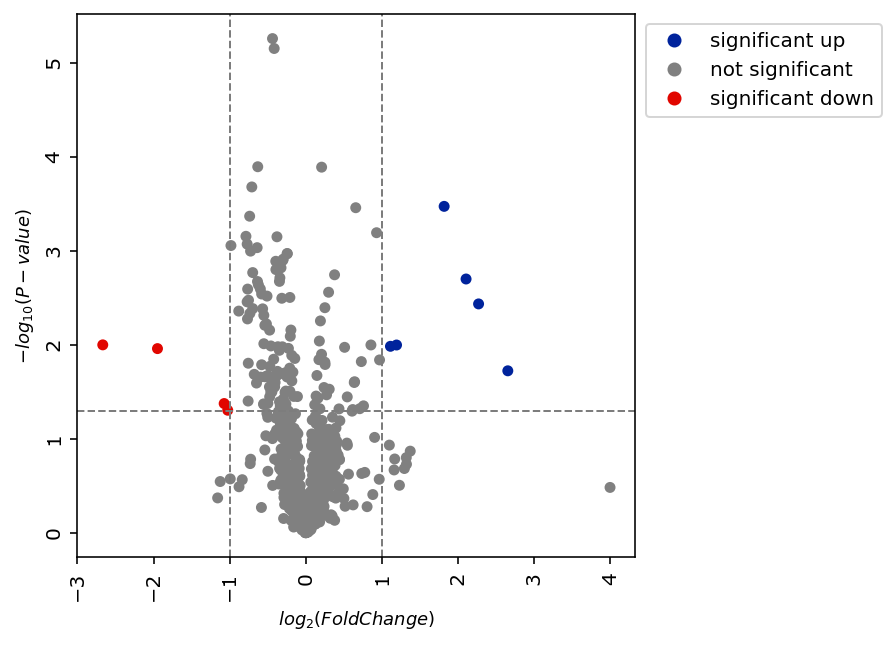

In [43]:
# Stage 2 volcano plots
vol_plot(vDF2, True)

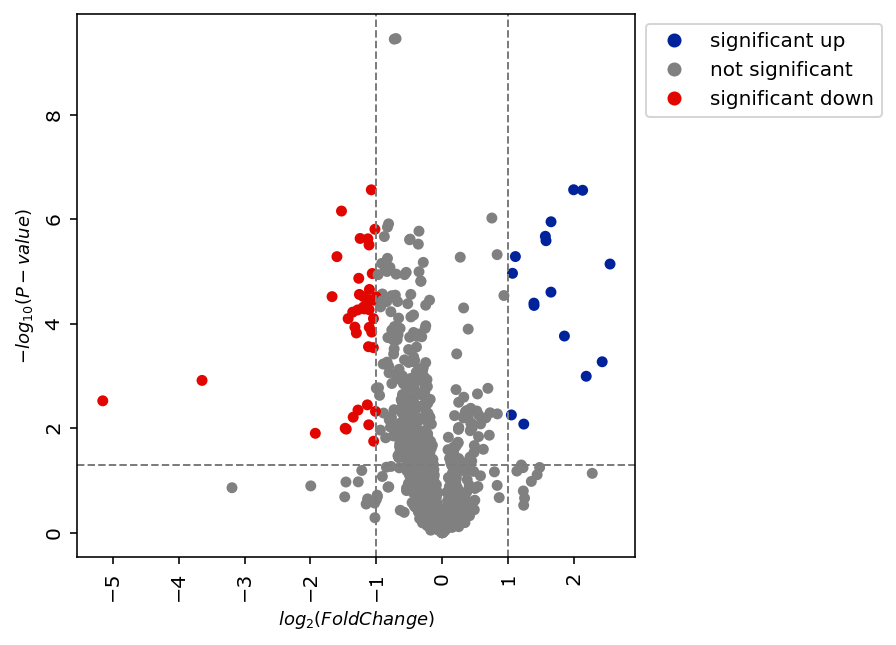

In [44]:
# Stage 3 volcano plots
vol_plot(vDF3, True)

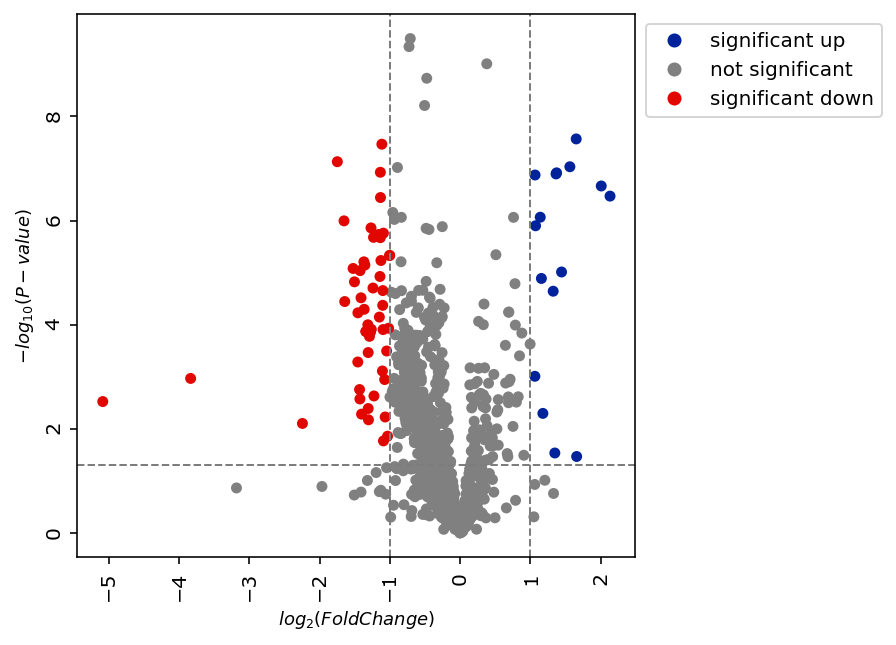

In [45]:
# Stage 4 volcano plots
vol_plot(vDF4, True)

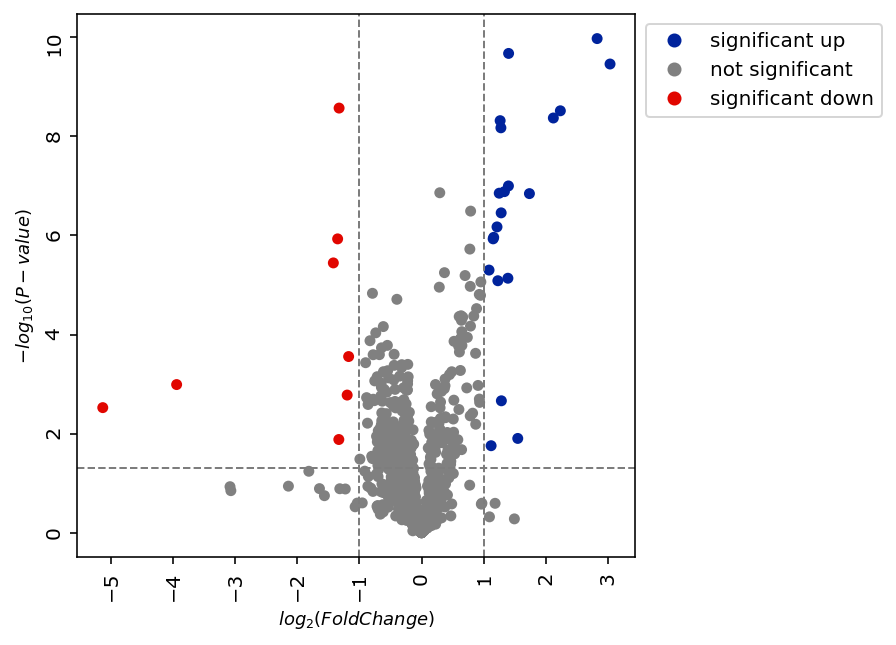

In [46]:
# Stage 5 volcano plots
vol_plot(vDF5, True)

**Run code for interactive volcano plot.** 

import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()

trace = go.Scatter(
    x=vDF['Log2Fold'], 
    y=vDF['-log(q-value)'], 
    mode='markers', 
    hovertext=volanoplot_DF['Features'])

fig.add_trace(trace)

fig.update_layout(title='Volcano plot')

fig.show()

**Selecting lipids that meets the cut-off.** 

In [47]:
# Cut-off of Log2Fold change > 1.0, < -1.0, and p-value < 0.5
"""
vDF.loc[((vDF['Log2Fold'] > 1.0) | (vDF['Log2Fold'] < -1)) & (vDF['p-value'] < 0.05)]
"""

sig_volcano2 = vDF2.loc[((vDF2['Log2Fold'] > 1.0) | (vDF2['Log2Fold'] < -1)) & (vDF2['p-value'] < 0.05)]
sig_volcano3 = vDF3.loc[((vDF3['Log2Fold'] > 1.0) | (vDF3['Log2Fold'] < -1)) & (vDF3['p-value'] < 0.05)]
sig_volcano4 = vDF4.loc[((vDF4['Log2Fold'] > 1.0) | (vDF4['Log2Fold'] < -1)) & (vDF4['p-value'] < 0.05)]
sig_volcano5 = vDF5.loc[((vDF5['Log2Fold'] > 1.0) | (vDF5['Log2Fold'] < -1)) & (vDF5['p-value'] < 0.05)]

Generate upset plots to look for intersection of significant lipids in the four volcano plots

In [48]:
from upsetplot import from_contents, UpSet, generate_counts, plot

In [49]:
plot_volcanosig = from_contents({'sig_stage2': sig_volcano2['Features'].tolist(), 
                          'sig_stage3': sig_volcano3['Features'].tolist(), 
                          'sig_stage4': sig_volcano4['Features'].tolist(),
                          'sig_stage5': sig_volcano5['Features'].tolist()
                                })

In [50]:
plot_volcanosig

id
sig_stage2 sig_stage3 sig_stage4 sig_stage5                                                   
True       True       True       True                                     ;;steroid hormone .1
                      False      False                               ;dehydrophytosphingosine;
                      True       True                                           FA(20:4-2OH).1
                      False      False                                               ;FA(18:3)
                                 False        6-methyl-1-(2-methylphenyl)-3-propylfuro[3,2-...
...                                                                                        ...
False      False      False      True                                  FA(20:4-OH);FA(20:4-OH)
                                 True                 FA(20:5);FA(20:5(5Z,8Z,11Z,14Z,17Z)));.1
                                 True                                           FA(20:4-2OH).2
                                 True                                                 FA(20:5)
                                 True                                      TG(54:8) M + NH3;.2

[90 rows x 1 columns]

In [51]:
#plot_upset = UpSet(plot_volcanosig, subset_size='count', show_counts=True).plot()

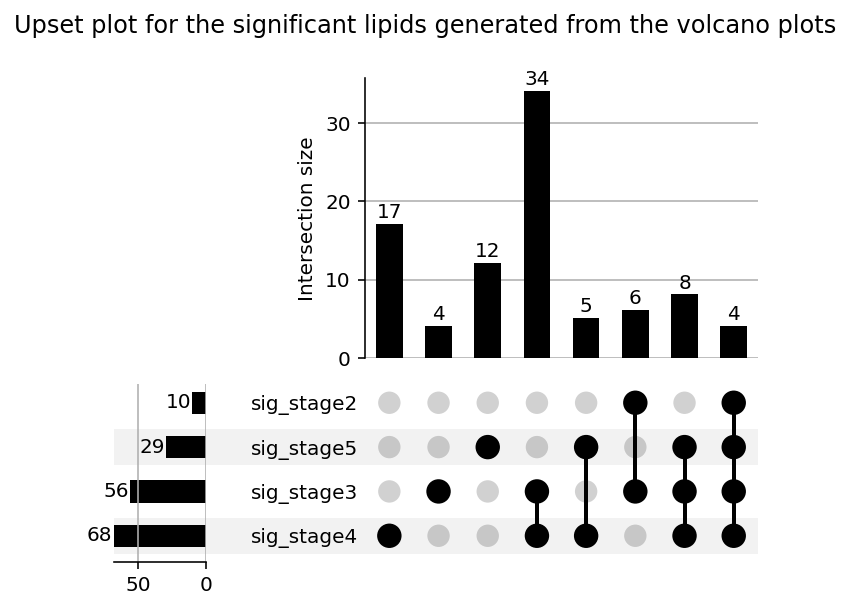

In [52]:
plot(plot_volcanosig, subset_size='count', show_counts=True)
plt.suptitle('Upset plot for the significant lipids generated from the volcano plots');
#plt.savefig('volcano_upsetplot.svg')

Focus on lipids that are significant in at least 3 volcano plots analysis. 

In [53]:
# A lists of list of lipids that overlaps in all four stages
all_sig_volcano = [sig_volcano2['Features'].tolist(), 
                   sig_volcano3['Features'].tolist(),
                   sig_volcano4['Features'].tolist(),
                   sig_volcano5['Features'].tolist()]

In [54]:
# A lists of list of lipids that overlaps in the last three stages

all_sig_volcano = [sig_volcano3['Features'].tolist(),
                   sig_volcano4['Features'].tolist(),
                   sig_volcano5['Features'].tolist()]

In [62]:
from functools import reduce
# run to list out intersection in the list of list. 
list(reduce(set.intersection, [set(item) for item in all_sig_volcano]))

[' ;PGF2a;PGF2a',
 ' 6,18,19-Trihydroxytrachyloban-2-one;PGA2;PGA2/PGB2',
 ' 16-Hydroxyhexadecanoic acid;FA(16:0-OH);FA(16:0-OH).1',
 ' ;;FA(17:0-OH)',
 ' 15-deoxy-?12,14-Prostaglandin A2;;',
 ' 6-Pentyl-2H-pyran-2-one;',
 ' PC(37:2);PC(37:2).2',
 ' (2R,3R,4S,5S,6R)-2-{[4-(4-hydroxy-2,6,6-trimethylcyclohex-1-en-1-yl)butan-2-yl]oxy}-6-(hydroxymethyl)oxane-3,4,5-triol;',
 ' ;;steroid hormone .1',
 ' 16-Hydroxyhexadecanoic acid;FA(16:0-OH);.1',
 ' PC(39:4);PC(39:4).3',
 'FA(20:4-2OH).1']

Retrieve the IDs of these lipids. 

In [63]:
lipid_compds = pd.read_excel('data/lipid_compounds_annotated_ids.xlsx')
lipid_compds = lipid_compds.iloc[:, 1:]

In [65]:
# As above.
prog_lipd_screen = list(reduce(set.intersection, [set(item) for item in all_sig_volcano]))

# Identify lipid IDs. 
prog_lipd_screen_ID = lipid_compds.loc[lipid_compds['Lipids'].isin(prog_lipd_screen)]
#prog_lipd_screen_ID.to_excel("prog_lipd_screen_ID.xlsx")

### [Go to Table of Contents](#0) <br>

### 5.3 Prognostic Lipid Candidates from Volcano Plots.

<a id='5.3'></a>

In [56]:
def prognostic_km(dataframe1, dataframe2, metabolite, quant=0.5, weight='peto'): 
    
    """
    prognostic_km function primarily plots out the KM cuvrve for a potential prognostic factor.  
    
    INPUTS:
    dataframe1: Complete dataframe, at the time of writing, dko_annotated_updated.xlsx (a pandas dataframe)
    dataframe2: survival analysis data, at the time of writing, survival_analysis_data.xlsx (a pandas dataframe)
    metabolite: name of metabolite of interest (string)
    quant: value of quantile (integer) default = 0.50, median. 
    weight: weightings for log rank test. Default = 'peto'
    # peto, wilcoxon, tarone-ware, fleming-harrington
    
    OUTPUTS:
    metaboKMv3: Dataframe for plotting the metabolite KM curve.(a pandas Dataframe) 
    ax: The K-M plot. (Figure)
    results.p_value: Log rank p-value (Float)
    
    
    """
    # Select DKO only dataframe
    DKOdf = dataframe1.loc[dataframe1['group'] == 'DKO']
    
    # Select stage 5 DKO dataframe.
    dko_five = DKOdf[DKOdf['stage_bin'] == 'V']
    
    # Select only `DKO` animals with percentage lifetime of 100%. 
    # In order to calculate and plot the KM estimates for the 
    # potential serum prognostic factors. 
    
    # take dko_five and select rows with lifetime==100. 
    metaboKMv1 = dko_five.loc[dko_five['lifetime'] == 100]
    
    # Select relevant column for dataframe merge, include metabolites of interest.
    metaboKMv2 = metaboKMv1[['mice', metabolite]] #remove age.
    
    # rename column mice to id for merging purposes. 
    metaboKMv2 = metaboKMv2.rename({'mice': 'id'}, axis='columns')
    
    # select DKO only data from the survival analysis dataframe.
    df_mouse_dko = dataframe2.loc[dataframe2['group'] == 'DKO']
    
    # merge dataframe on id. 
    metaboKMv3 = pd.merge(metaboKMv2, df_mouse_dko, on='id')
    
    # Select a quantile value that will be used to split the samples.
    med = metaboKMv3[metabolite].quantile(quant)
    
    # Compute the median or quantile split.
    metaboKMv3[metabolite] = metaboKMv3[metabolite].apply(lambda x: ('low' if x <= med else 'high'))
    
    # Select age and event columns
    age = metaboKMv3['age']
    event = metaboKMv3['event']
    
    # Select groups
    groups = metaboKMv3[metabolite]
    ix = (groups == 'high')
    
    # Plot the KM curve
    plt.figure(figsize=(6,5))
    kmf.fit(age[~ix], event[~ix], label='low', timeline=range(15, 50))
    ax = kmf.plot_survival_function(ci_show=False)

    #plt.figure(figsize=(6,5))
    kmf.fit(age[ix], event[ix], label='high', timeline=range(15, 50))
    ax = kmf.plot_survival_function(ax=ax, ci_show=False)

    ax.set_xlabel("Age(weeks)", fontsize=15)
    ax.set_ylabel("Survival Probability", fontsize=15);
    ax.set_title("KM survial curves for Metabolite", 
                 fontsize=15);
    
    # Log rank tests. 
    age_exp, event_exp = metaboKMv3.loc[ix, 'age'], metaboKMv3.loc[ix, 'event']
    age_con, event_con = metaboKMv3.loc[~ix, 'age'], metaboKMv3.loc[~ix, 'event']
    
    results = logrank_test(age_exp, 
                       age_con, 
                       event_observed_A = event_exp, 
                       event_observed_B = event_con, 
                       weightings = 'peto') # peto, wilcoxon, tarone-ware, fleming-harrington
    
    #For more comprehensive log rank test results, use this:
    #results.print_summary()
    
    return metaboKMv3, plt.show, results.p_value

From the analysis above two lipids found to be a potential prognostic factor.
- ' PC(39:4);PC(39:4).3' (from Volcano DKO base _vs_ DKO experimental)
- ' PC(37:2);PC(37:2).2' (from Volcano DKO base _vs_ DKO experimental)

0.0033231575344757386


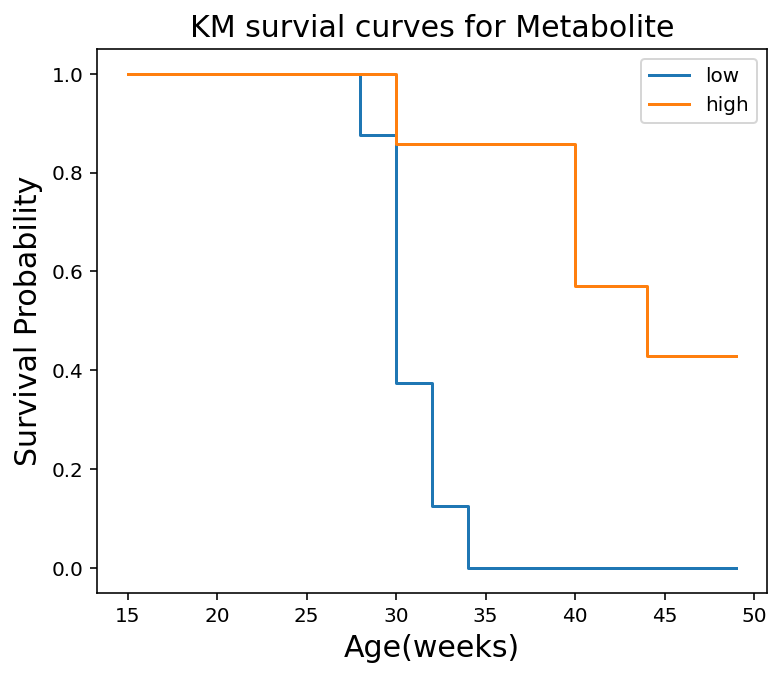

In [57]:
a, b, c = prognostic_km(df, df_mouse, ' PC(39:4);PC(39:4).3', quant=0.50, weight='peto');
print(c)
#plt.savefig('PC(39:4).svg')

0.02301806152719687


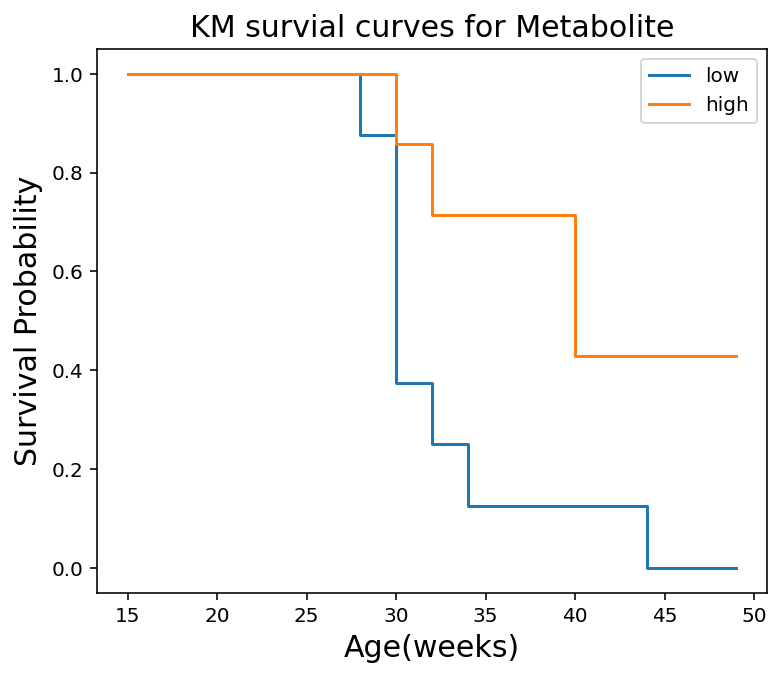

In [58]:
a, b, c = prognostic_km(df, df_mouse, ' PC(37:2);PC(37:2).2', quant=0.50, weight='peto');
print(c)
#plt.savefig('PC(37:2).svg')

### [Go to Table of Contents](#0) <br>

### 5.4 Feature Selection: _T_-test results from DKO _vs_ Control Comparison

<a id='5.4'></a>

In [66]:
df.head()

,Unnamed: 0,id,mice,timepoint,age,lifetime,stage_bin,death,group,;;FA(11:2),...,TG(58:9) M + NH3;.1,TG(58:9) M + NH3;.2,TG(58:9) M + NH3;.3,TG(58:9) M + NH3;.4,TG(58:9) M + NH3;.5,TG(58:9) M + NH3;.6,TG(60:3) M + NH3;,ubiquinol(Q10)_M+NH3;,cholesterol derivative,"(2R,3R,4S,5S,6R)-2-{[4-(4-hydroxy-2,6,6-trimethylcyclohex-1-en-1-yl)butan-2-yl]oxy}-6-(hydroxymethyl)oxane-3,4,5-triol;"
0,0,NC15_T20,NC15,T20,46,100.00,V,46,control,1.055509e+06,...,3.385786e+09,2.183883e+08,2.267883e+08,5.409523e+08,3.102343e+09,4.075240e+08,6.375668e+07,9.163258e+06,3.968544e+07,6.712394e+05
1,1,NC1_T1,NC1,T01,8,25.00,I,32,control,7.127085e+05,...,2.622828e+09,2.350839e+08,2.302809e+08,4.992443e+08,2.429847e+09,1.578130e+08,1.521046e+07,1.716687e+07,1.402221e+07,1.170909e+07
2,2,NC1_T2,NC1,T02,10,31.25,II,32,control,2.990010e+05,...,3.418390e+09,3.109862e+08,4.096705e+08,9.708473e+08,3.213337e+09,3.516522e+08,1.018904e+08,1.938169e+07,7.830400e+07,2.999685e+06
3,3,NC1_T3,NC1,T03,12,37.50,II,32,control,1.029501e+05,...,1.261545e+09,1.320493e+08,1.402461e+08,2.613283e+08,1.190903e+09,2.856952e+08,2.726481e+07,2.324582e+06,2.186917e+07,2.879285e+06
4,4,NC1_T4,NC1,T04,14,43.75,II,32,control,2.622025e+05,...,6.118623e+09,5.576515e+08,5.423552e+08,1.040067e+09,5.774111e+09,5.182529e+08,1.783335e+08,2.445218e+07,1.392878e+08,1.226697e+06


In [68]:
# define our features, all metabolomic features.  
features = df.drop(['Unnamed: 0', 'id', 'group', 'mice', 'timepoint', 'age',
                            'lifetime', 'stage_bin', 'death'], axis=1).columns

In [70]:
timepoints = ['I', 'II', 'III', 'IV', 'V']
store = []
for i in timepoints:
    control = df.drop(['id', 'mice'], axis=1)[df['stage_bin']==i][df['group']=='control']
    DKO = df.drop(['id', 'mice'], axis=1)[df['stage_bin']==i][df['group']=='DKO']
    
    # dataframe showing full ttest result.
    ttest_result = Ttest(features, control, DKO, alpha=0.05, var=False)
    
    # Select metabolites with <0.05 t-test
    stat_sig = ttest_result.loc[ttest_result['T-test p-value'] <= 0.05]
    
    # list of statistically relevant metabolites
    # select metabolites with <0.05 FDR
    # stat_sig = ttest_result.loc[ttest_result['Reject H0'] == True]
    
    # store metabolites in each stage bins
    store.append(stat_sig['Metabolite'].to_list())
    
    # store the number of sig metabolites in the list store. 
    #store.append(len(stat_sig))
    
#print(store)

In [74]:
store;

In [75]:
# Statistically significant lipids for each lifetime stage. 
sig_stage1 = store[0]
sig_stage2 = store[1]
sig_stage3 = store[2]
sig_stage4 = store[3]
sig_stage5 = store[4]

In [76]:
plot_sig = from_contents({'sig_stage1': sig_stage1, 
                          'sig_stage2': sig_stage2, 
                          'sig_stage3': sig_stage3,
                          'sig_stage4': sig_stage4,
                          'sig_stage5': sig_stage5})

In [77]:
plot_sig

id
sig_stage1 sig_stage2 sig_stage3 sig_stage4 sig_stage5                                      
True       False      False      False      False                        PC(38:5);PC(38:5).1
           True       False      True       True                       PC(O-38:4);PC(O-38:4)
           False      False      False      False                             Cer(t41:0);;.1
                                            False        PC(34:3)>PC(16:0_18:3) M + CH3COOH;
                                            False                                 ;;FA(17:2)
...                                                                                      ...
False      False      False      False      True                           PC(34:2);PC(34:2)
                                            True                              CE(20:4)M+NH3;
                                            True                      PE(34:1)>PE(16:0_18:1)
                                            True                                ;PE(O-39:7);
                                            True          TG(50:1)>TG(16:0_16:0_18:1)_M+NH3;

[482 rows x 1 columns]

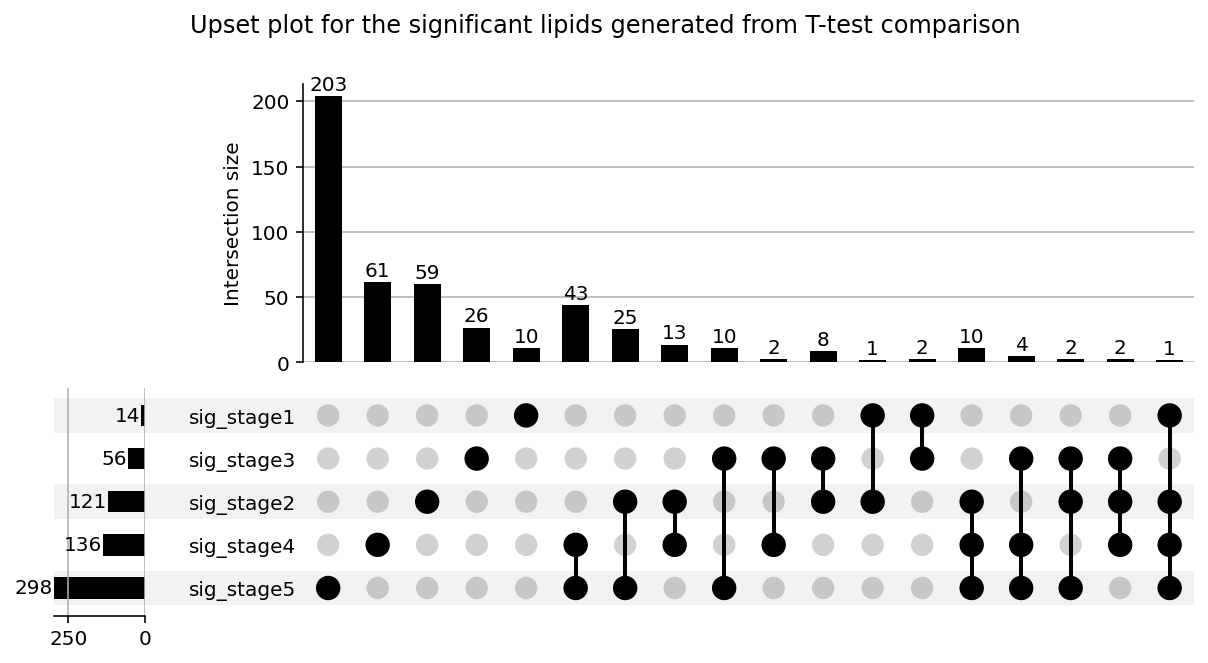

In [78]:
plot(plot_sig, subset_size='count', show_counts=True)
plt.suptitle('Upset plot for the significant lipids generated from T-test comparison');
#plt.savefig('Ttest_upsetplot.svg')

Select intersections with at least 3 stages. 

In [79]:
TP1 = ['II', 'IV', 'V']
TP2 = ['III', 'IV', 'V']
TP3 = ['II', 'III', 'V']
TP4 = ['II', 'III', 'IV']
TP5 = ['I', 'II', 'IV', 'V']

In [80]:
from functools import reduce

In [81]:
def overlap_features(timepoints):
    
    '''
    Function: Selects the overlapping features for the t-test result from 
    the comparison of DKO and Control for selected stages. 
    Input: A list of stages
    Output: A list of overlapping features. 
    
    '''
    
    
    store = []
    sig_metabolite_list = []
    for i in timepoints:
        control = df.drop(['id', 'mice'], axis=1)[df['stage_bin']==i][df['group']=='control']
        DKO = df.drop(['id', 'mice'], axis=1)[df['stage_bin']==i][df['group']=='DKO']
        # dataframe showing full ttest result.
        ttest_result = Ttest(features, control, DKO, alpha=0.05, var=False)
    
        # Select metabolites with <0.05 t-test
        stat_sig = ttest_result.loc[ttest_result['T-test p-value'] <= 0.05]
    
        # list of statistically relevant metabolites
        # select metabolites with <0.05 FDR
        # stat_sig = ttest_result.loc[ttest_result['Reject H0'] == True]
    
        # collect significant metabolites in a list. 
        sig_metabolite_list.append(stat_sig['Metabolite'].tolist())
        
    # Select overlapping lipids. 
    overlap_metabolites = list(reduce(set.intersection, [set(item) for item in sig_metabolite_list]))
    return overlap_metabolites

In [82]:
overlap_features(TP2)

[' Prostaglandin A1 ethyl ester;;',
 ' Cer(d33:1) M + CH3COOH;;',
 ' Cer(d41:2) M + CH3COOH;;',
 ' PC(O-40:7);PC(O-40:7).3']

In [89]:
# Get all of the features that had intersection with at least 3 stages. 
sig_features_time = [overlap_features(TP1),
                     overlap_features(TP2),
                     overlap_features(TP3),
                     overlap_features(TP4),
                     overlap_features(TP5)]

In [93]:
# Flatten the list of list. 
sig_features_time_overlap = [item for sublist in sig_features_time for item in sublist]

In [100]:
# Identify lipid IDs. 
sig_features_time_overlap_ID = lipid_compds.loc[lipid_compds['Lipids'].isin(sig_features_time_overlap)]
#sig_features_time_overlap_ID.to_excel("sig_features_time_overlap_ID.xlsx")

In [101]:
sig_features_time_overlap_ID.shape

(19, 3)

In [560]:
# import survival analysis data
#df_mouse = pd.read_excel('data/survival_analysis_data.xlsx')

# import the complete analysis data
#df = pd.read_excel('data/dko_annotated_updated.xlsx')

### [Go to Table of Contents](#0) <br>

### 5.5 Prognostic Lipid Candidates from _T_-test DKO _vs_ Control Comparison.

<a id='5.5'></a>

0.008892806901941594


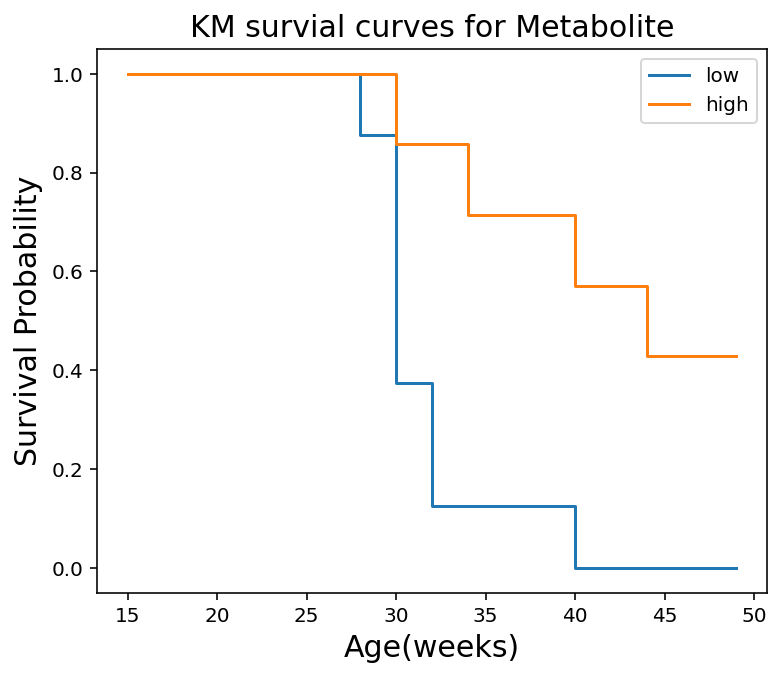

In [561]:
a, b, c = prognostic_km(df, df_mouse, ' PC(O-40:7);PC(O-40:7).3', quant=0.50, weight='peto');
print(c)
#plt.savefig('PC(40:7).svg')

In [562]:
# Sample size for each group
a.iloc[:, 1:2].value_counts()

 PC(O-40:7);PC(O-40:7).3
low                         8
high                        7
dtype: int64

In [563]:
b

<function matplotlib.pyplot.show(close=None, block=None)>

In [564]:
c

0.008892806901941594

### [Go to Table of Contents](#0) <br>

### 5.6 RMST for Prognostic Circulating Lipids Candidates

<a id='5.6'></a>

In [656]:
# Select DKO only dataframe
DKOdf = df.loc[df['group'] == 'DKO']
    
# Select stage 5 DKO dataframe.
dko_five = DKOdf[DKOdf['stage_bin'] == 'V']
    
# Select only `DKO` animals with percentage lifetime of 100%. 
# In order to calculate and plot the KM estimates for the 
# potential serum prognostic factors. 
    
# take dko_five and select rows with lifetime==100. 
metaboKMv1 = dko_five.loc[dko_five['lifetime'] == 100]

**The Three Lipid Candidates** <br>
' PC(39:4);PC(39:4).3' <br>
' PC(37:2);PC(37:2).2' <br>
' PC(O-40:7);PC(O-40:7).3' <br>

In [657]:
# Select relevant column for dataframe merge, include metabolites of interest.
metaboKMv2 = metaboKMv1[['mice', ' PC(O-40:7);PC(O-40:7).3']] #remove age.
    
# rename column mice to id for merging purposes. 
metaboKMv2 = metaboKMv2.rename({'mice': 'id'}, axis='columns')
    
# select DKO only data from the survival analysis dataframe.
df_mouse_dko = df_mouse.loc[df_mouse['group'] == 'DKO']
    
# merge dataframe on id. 
metaboKMv3 = pd.merge(metaboKMv2, df_mouse_dko, on='id')

# Select a quantile value that will be used to split the samples.
med = metaboKMv3[' PC(O-40:7);PC(O-40:7).3'].quantile(0.50)
    
# Compute the median or quantile split.
metaboKMv3[' PC(O-40:7);PC(O-40:7).3'] = metaboKMv3[' PC(O-40:7);PC(O-40:7).3'].apply(lambda x: ('low' if x <= med else 'high'))
    
# Select age and event columns
age = metaboKMv3['age']
event = metaboKMv3['event']
    
# Select groups
groups = metaboKMv3[' PC(O-40:7);PC(O-40:7).3']
ix = (groups == 'high')

In [658]:
time_limit = 46
#age, event = df_mouse['age'], df_mouse['event']

kmf_exp = KaplanMeierFitter().fit(age[ix],event[ix], label='High')
rmst_exp = restricted_mean_survival_time(kmf_exp, t=time_limit)

kmf_con = KaplanMeierFitter().fit(age[~ix],event[~ix], label='Low')
rmst_con = restricted_mean_survival_time(kmf_con, t=time_limit)

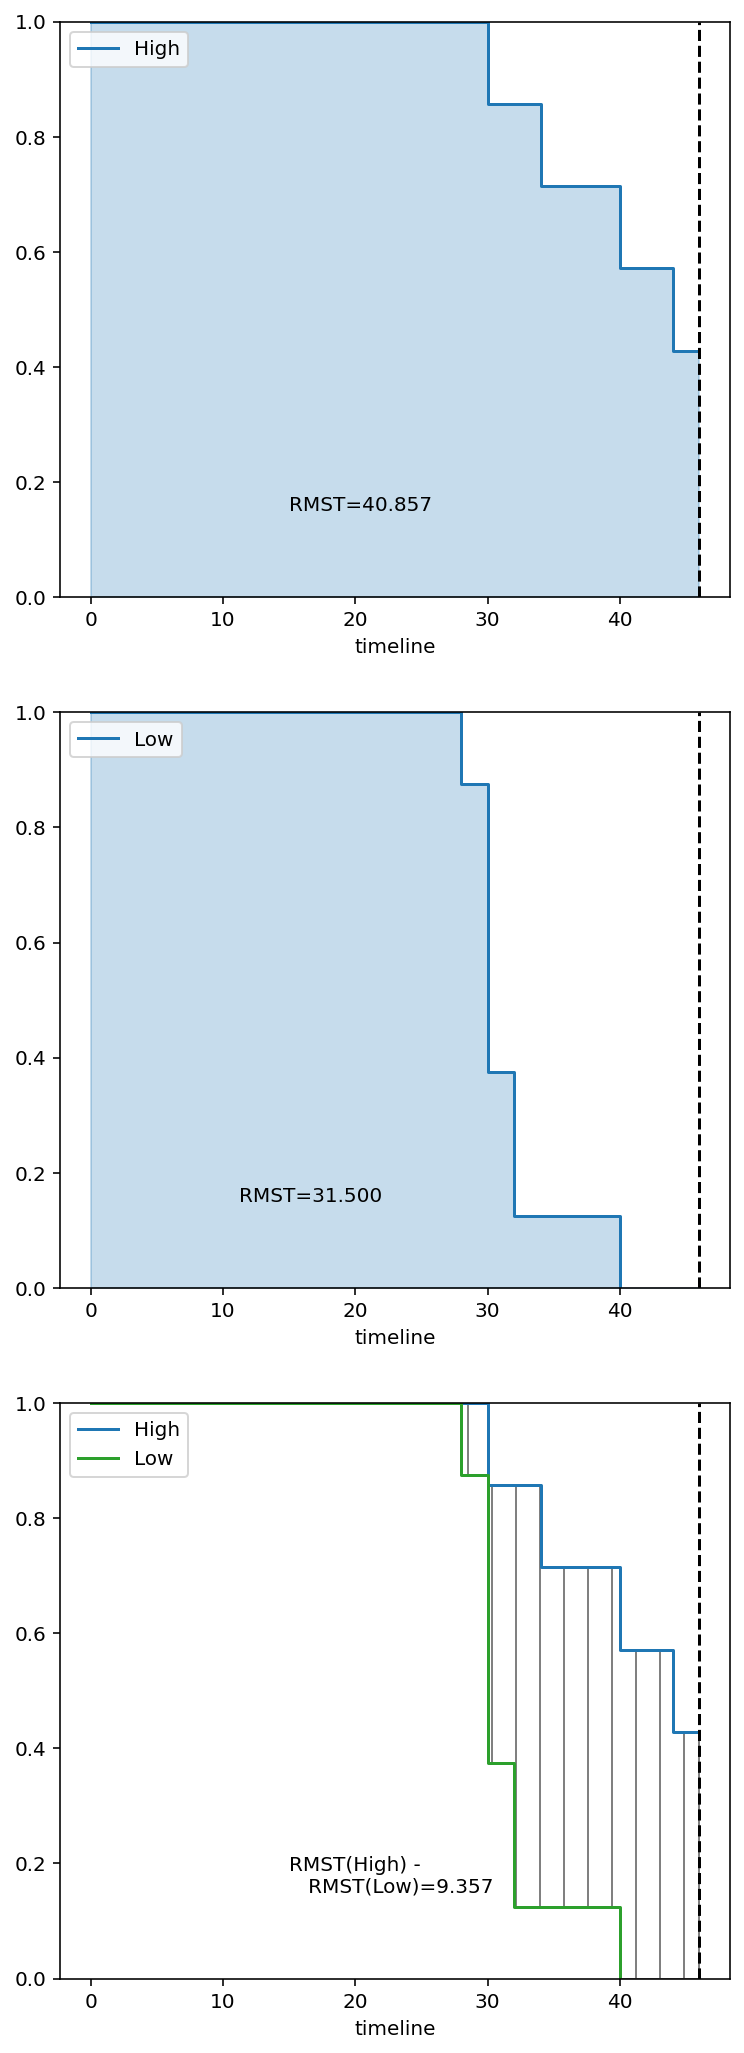

In [659]:
plt.figure(figsize=(6,6))
ax = plt.subplot(311)
rmst_plot(kmf_exp, t=time_limit, ax=ax, figsize=(6,18))


ax = plt.subplot(312)
rmst_plot(kmf_con, t=time_limit, ax=ax)


ax = plt.subplot(313)
rmst_plot(kmf_exp, model2=kmf_con, t=time_limit, ax=ax);
#plt.savefig('RMST-PC(40:7).svg')

### [Go to Table of Contents](#0) <br>

## 6. Reading List and Code References

<a id='6'></a>

- **Textbook**:[ David G. Kleinbaum Mitchel Klein, Survival Analysis: A Self‐Learning Text Third Edition](https://link.springer.com/book/10.1007/978-1-4419-6646-9)
- **Blog post [with code]**:[ A Complete Guide To Survival Analysis In Python](https://www.kdnuggets.com/2020/07/complete-guide-survival-analysis-python-part1.html)
- **Paper**: [Counterfactual explanation of machine learning survival models](https://arxiv.org/pdf/2006.16793.pdf)
- **Paper**: [ SurvLIME-Inf: A simplified modification of SurvLIME for explanation of machine learning survival models](https://arxiv.org/pdf/2005.02387.pdf)
- **Python survival analysis module**: [scikit-survival](https://scikit-survival.readthedocs.io/en/stable/index.html)
- **Paper**: [Explainable machine learning can outperform Cox regression predictions and provide insights in breast cancer survival](https://www.nature.com/articles/s41598-021-86327-7.pdf)
- **YouTube video**: [Survival Analysis in Python [Time to event analysis]](https://www.youtube.com/watch?v=PH2o_KVF7Jw)

- **Course**: [Specialized Models: Time Series and Survival Analysis](https://www.coursera.org/learn/time-series-survival-analysis)
- **Lecture**: [Machine Learning for Survival Analysis: Theory, Algorithms and Applications part 1](https://www.youtube.com/watch?v=GpIk1NhZiVU)
- **Lecture**: [Machine Learning for Survival Analysis: Theory, Algorithms and Applications part 2](https://www.youtube.com/watch?v=0UzwYWP9f8U)
- **Paper**: [Machine Learning for Survival Analysis: A Survey](https://arxiv.org/pdf/1708.04649.pdf)
- **Slide**: [Machine Learning for Survival Analysis](https://dmkd.cs.vt.edu/TUTORIAL/Survival/Slides.pdf)